## 載入預訓練模型(Inception V3)

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input

# 建立一個輸入張量，指定圖像大小為224x224（RGB色彩通道）
input_tensor = Input(shape=(224, 224, 3))
# 建立 InceptionV3 模型
model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)

2023-09-15 18:49:43.340746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 18:49:44.167253: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-15 18:49:44.167335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-15 18:49:44.167342: W tensorfl

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

# 載入圖像
image = tf.keras.utils.load_img('https://raw.githubusercontent.com/andy6804tw/2023-15th-ironman/main/dataset/cat_dog.jpg')
image = tf.keras.utils.img_to_array(image) # 將載入的圖像轉換為數組形式
x = np.expand_dims(image.copy(), axis=0) # 將圖像轉換為模型可接受的維度
# 預處理圖像
x = preprocess_input(x)

In [6]:
from tensorflow.keras.applications.inception_v3 import decode_predictions

# 進行圖像分類預測
pred_proba = model.predict(x) # 返回分類機率
# 解析預測結果
pred_class_idx = pred_proba.argmax(axis=1)[0]  # 找到具有最高機率的類別索引
pred_class = decode_predictions(pred_proba, top=1)[0][0]  # 解析取得預測結果

1/1 [==============================] - 0s 42ms/step


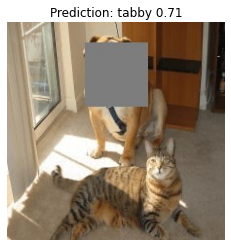

In [7]:
import matplotlib.pylab as plt

plt.imshow(image.astype('uint8'))
plt.axis('off')
predicted_class_name = pred_class[1]
_ = plt.title(f"Prediction: {predicted_class_name} {pred_class[2]:.2f}")

## Occlusion Sensitivity 實作
以下實現 Occlusion Sensitivity 方法，它對原始影像依序插入灰色方塊(patch)，然後遍歷這些方塊並計算它們對於模型預測的影響，最後生成 sensitivity_map 和 coordinates 以供進一步分析使用。由於影像大小為`224*224`，而每個 patch 大小 `75*75` 因此總共會生成 9 張圖並儲存在 patches。以下為整個流程的前置作業，先把遮擋的圖像與原圖合成，並初始化 sensitivity_map 為0，以及生成一個座標網格 coordinates 以利於後續實作。

In [22]:
import math

batch_size = 16 # 批次大小，設定模型一次預測可以讀取幾張照片
patch_size = 75 # 方形灰色方塊大小
target_class_idx = pred_class_idx # 預測目標的標籤索引

# 定義一個函數，用於將灰色方塊(patch)置換到原始影像的指定位置
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    # 置換指定區域的像素值為灰色（127.5），達到遮蔽的效果
    patched_image[
        top_left_y : top_left_y + patch_size, top_left_x : top_left_x + patch_size, :
    ] = 127.5

    return patched_image

# 用於記錄不同區域對於模型預測的影響(初始化為0)
sensitivity_map = np.zeros(
    (
        math.ceil(image.shape[0] / patch_size),
        math.ceil(image.shape[1] / patch_size),
    )
)
# 儲存所有遮擋的圖像
patches = [
    apply_grey_patch(image, top_left_x, top_left_y, patch_size)
    for index_x, top_left_x in enumerate(range(0, image.shape[0], patch_size))
    for index_y, top_left_y in enumerate(range(0, image.shape[1], patch_size))
]
# 建立一個坐標列表，用於記錄不同區域的坐標
coordinates = [
    (index_y, index_x)
    for index_x in range(
        sensitivity_map.shape[1]
    )
    for index_y in range(
        sensitivity_map.shape[0]
    )
]

遮擋圖片都已準備好後，接著觀察每個方塊的不同位置遮擋對於模型預測的影響。我們將影像進行前處理，接著餵入先前已建立好的 Inception V3 模型，然後提取特定類別的預測機率值，在本範例中我們要觀察 bull_mastiff 類別的機率，最終這些機率值存儲在 target_class_probs 中供後續使用。

In [23]:
# 建立模型輸入資料
inputs = np.array(patches, copy=True)
# 預處理圖像
inputs = preprocess_input(inputs)
# 進行圖像分類預測
pred_proba = model.predict(inputs, batch_size=batch_size)
pred_proba = np.array(pred_proba)
# 取得 bull_mastiff 類別的機率
target_class_probs = [
    prob[target_class_idx] for prob in pred_proba
]

1/1 [==============================] - 0s 118ms/step


將各個含有灰色方塊的影像當成輸入影像丟進模型預測後，看預測出對應類別的機率值為多少。

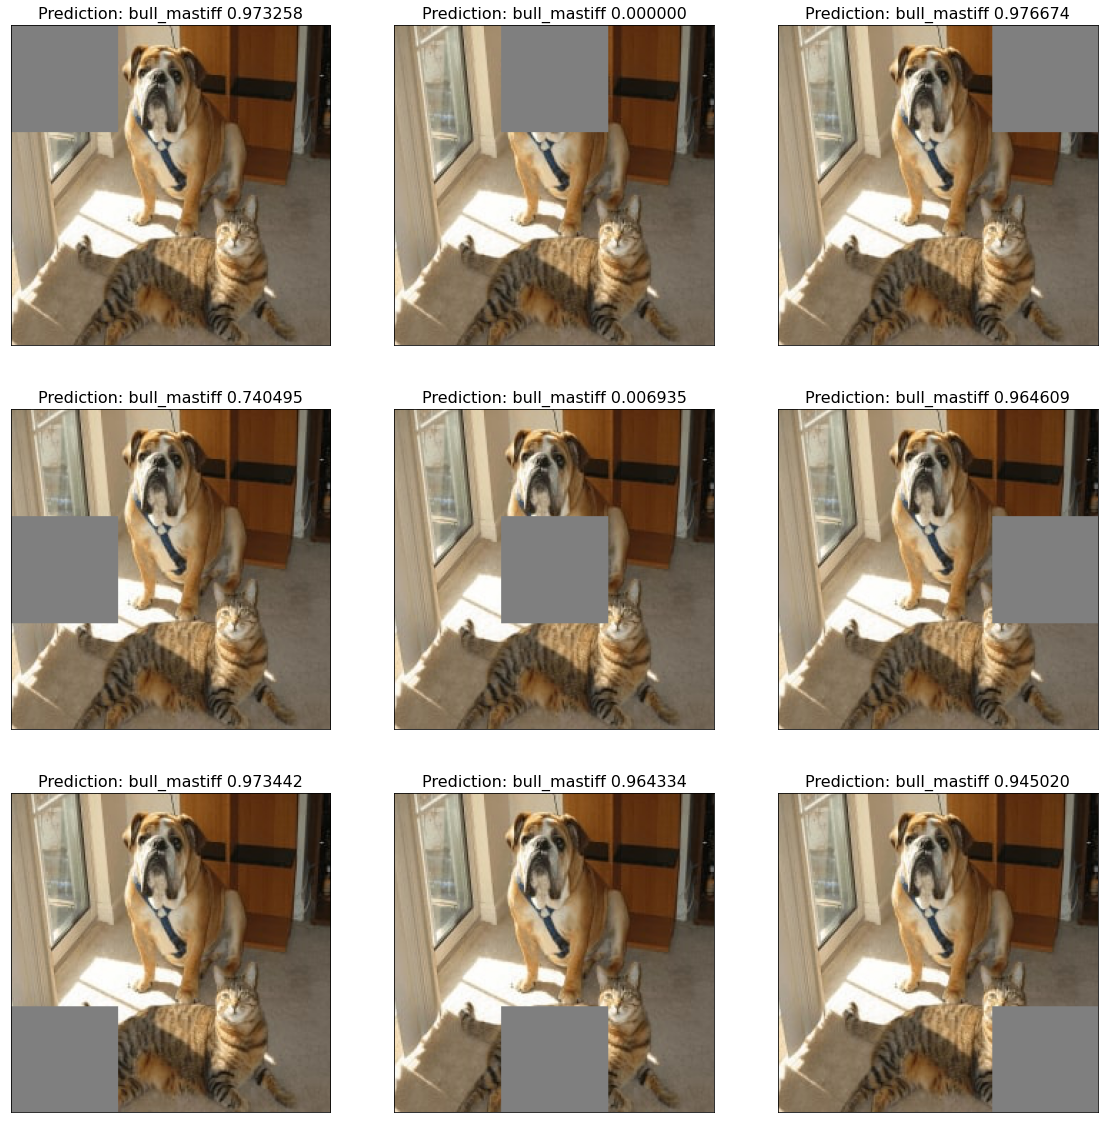

In [24]:
# 計算網格大小，繪圖排版用
grid = math.ceil(image.shape[0]/patch_size)
# 建立一張圖包含多個子圖，並設定圖像的大小和排列方式
fig, ax = plt.subplots(nrows=grid, ncols=grid, figsize=(20, 20),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.2, wspace=0.1))
# 顯示每張遮擋版本的圖像
for i in range(len(patches)):
    # 設定每個子圖像的標題，包括預測的類別名稱和相應的機率值
    ax[i%grid, i//grid].set_title(f'Prediction: {predicted_class_name} {target_class_probs[i]:.6f}', fontsize=16)
    # 顯示子圖像，並將像素值除以255以將其正規化到0到1之間
    ax[i%grid, i//grid].imshow(patches[i]/255)

In [27]:
import cv2
import matplotlib.cm as cm

# 將 (1-機率值) 當成是那塊 patch 的重要性
for (index_y, index_x), confidence in zip(coordinates, target_class_probs):
    sensitivity_map[index_y, index_x] = 1 - confidence
# 調整為與原始圖像相同的大小
sensitivity_maps = cv2.resize(sensitivity_map, tuple(image.shape[0:2]))

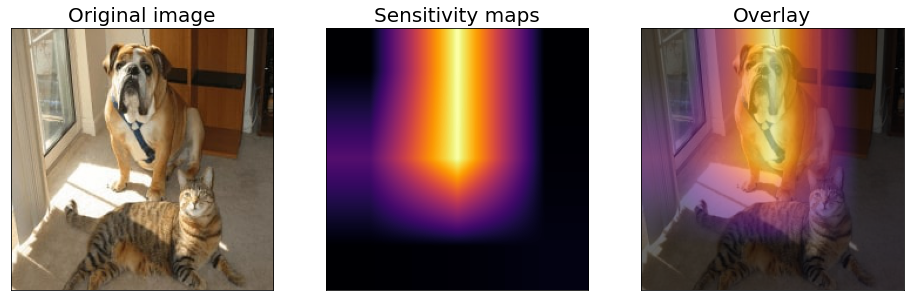

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Sensitivity maps', fontsize=20)
axs[0, 1].imshow(sensitivity_maps, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(sensitivity_maps, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

## Reference
- [圖片預處理使用Keras applications 的 preprocess_input](https://medium.com/@sci218mike/%E5%9C%96%E7%89%87%E9%A0%90%E8%99%95%E7%90%86%E4%BD%BF%E7%94%A8keras-applications-%E7%9A%84-preprocess-input-6ef0963a483e)